In [198]:
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from captum.attr import IntegratedGradients
from collections import defaultdict
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

In [1]:
class MalConv(nn.Module):
    def __init__(self, input_length, window_size=500):
        super().__init__()

        self.embed = nn.Embedding(257, 8, padding_idx=0)

        self.conv_1 = nn.Conv1d(8, 128, window_size, stride=window_size, bias=True)
        self.conv_2 = nn.Conv1d(8, 128, window_size, stride=window_size, bias=True)

        self.pooling = nn.MaxPool1d(int(input_length/window_size))


        self.fc_1 = nn.Linear(128,128)
        self.fc_2 = nn.Linear(128,1)

        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()


    def forward(self,x):
        x = self.embed(x)
        x = torch.transpose(x,-1,-2)

        cnn_value = self.relu(self.conv_1(x))
        gating_weight = self.sigmoid(self.conv_2(x))

        x = cnn_value * gating_weight
        x = self.pooling(x)
        x = torch.squeeze(x)

        x = self.relu(self.fc_1(x))
        x = self.sigmoid(self.fc_2(x))

        return x

/opt/conda/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
max_len = 10_000

model = MalConv(input_length=max_len)
model.load_state_dict(torch.load('./data/malconv_weights.pt'))
model.cuda()

MalConv(
  (embed): Embedding(257, 8, padding_idx=0)
  (conv_1): Conv1d(8, 128, kernel_size=(500,), stride=(500,))
  (conv_2): Conv1d(8, 128, kernel_size=(500,), stride=(500,))
  (pooling): MaxPool1d(kernel_size=20, stride=20, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=128, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

In [139]:
data = np.load('./data/samples.npy')
inp = Tensor(data.astype(np.int64)).long().cuda()
outp = model(inp)

In [151]:
inp.shape

torch.Size([5, 10000])

In [140]:
outp

tensor([[0.9663],
        [0.9702],
        [0.9884],
        [0.9984],
        [1.0000]], device='cuda:0', grad_fn=<SigmoidBackward0>)

----------------

In [142]:
def forward_func(embedded_input):
    # The challenge is the categorical data, which is handled by the model's embedding layer. We can extract that layer in order to convert our data
    # from categorical to float prior to inputing it into the model. Since the model is trained, we should still be getting the attribution including the embedding layer. 
    # This was the major element that was tripping me up earlier. But since the model is trained, we can recompose its forward function with the weights. 
    embedded_input = embedded_input.transpose(1, 2)
    cnn_value = model.relu(model.conv_1(embedded_input))
    gating_weight = model.sigmoid(model.conv_2(embedded_input))

    x = cnn_value * gating_weight
    x = model.pooling(x)
    x = torch.squeeze(x)

    x = model.relu(model.fc_1(x))
    x = model.sigmoid(model.fc_2(x))

    return x

def postprocess_attrs(attributions):
    # Attribution dimension matches the embedding dimension, so it has to be aggregated somehow. 
    # I sum the dimensions for each sample, and then divide by the norm, rather than just taking mean or sum, but how the aggregations affect the attributions should be explored:
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions) 
    return attributions.cpu().detach().numpy()

def get_top_feature_indices(attributions):
    # I want to get the sorted indices by magnitude of attribution
    attributions = postprocess_attrs(attributions)
    abs_attributions = np.abs(attributions) # sign doesn't matter, only magnitude of importance 
    return np.argsort(-abs_attributions)

In [143]:
ig = IntegratedGradients(forward_func)

In [130]:
target_class = 0.0
classification_flipped = False

In [194]:
def manipulate_classification(inp, target_class=0.0, classification_flipped=False):
    # count to keep track of individual changes made
    count = 0
    outputs = []
    modified_data = inp.clone()
    while not classification_flipped:
        # stopping condition is changing the classification 
        input_embeddings = model.embed(modified_data).cuda()
        baseline = torch.zeros_like(input_embeddings).cuda()
        # compute attributions for each iteration
        attributions = ig.attribute(input_embeddings.unsqueeze(0), 
                                       baseline.unsqueeze(0), 
                                       target=0)
        attributions = get_top_feature_indices(attributions)
        # iterate over attributions starting with the index with the highest attribution
        for idx in attributions:
            original_value = modified_data[idx]
            # simple heuristic of increasing by 1 mod 257
            
            new_value = (original_value + 1) % 257
            modified_data[idx] = new_value
            count+=1
            # Check the new output
            new_output = model(modified_data)
            new_output_numpy = new_output.detach().cpu().numpy()[0]
            outputs.append(new_output_numpy)
            # check stopping condition
            if new_output_numpy < 0.5:
                classification_flipped = True
                break

            # If none of the changes resulted in a different output, break
            if torch.equal(inp, modified_data):
                print("Not successful in changing classificaiton label")
                break
    return count, outputs

{0: 628, 1: 885, 2: 194, 3: 657, 4: 384}

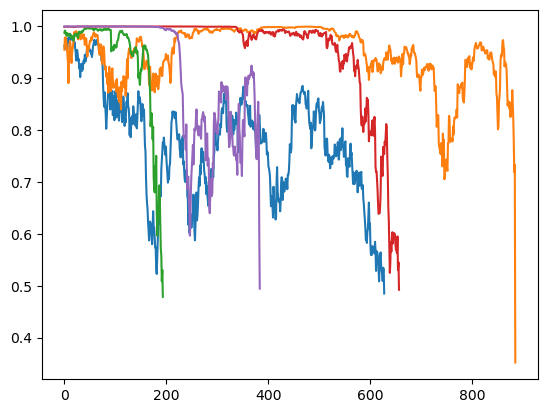

In [203]:
result = {}
for i, sample in enumerate(inp):
    count, label = manipulate_classification(inp[i])
    result[i] = count
    plt.plot(label)
result